In [1]:
from typing import List, Dict

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df, convert_numeric_to_float16
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.util_functions import *
from oop_functions.analytics_utils import get_per_thereshold_metrics

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import itertools

from dcurves import dca, plot_graphs


In [2]:
cv_analytics_utils: Dict[str, CvAnalyticsUtil] = {}

In [3]:

# https://xgboost.readthedocs.io/en/latest/parameter.html
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier_entropy': RandomForestClassifier(criterion= 'entropy', n_estimators= 200), # Best one
    'RandomForestClassifier': RandomForestClassifier(criterion='entropy', n_estimators=300), # Best one
    # 'RandomForestClassifier_log_loss': RandomForestClassifier(criterion= 'log_loss', n_estimators= 300),
    # 'RandomForestClassifier_gini': RandomForestClassifier(criterion= 'gini', n_estimators= 300),
    # 'XGBClassifier_error': XGBClassifier(eval_metric= 'error', learning_rate=0.1),
    'XGBClassifier': XGBClassifier(eval_metric= 'logloss', learning_rate=0.1), # Best one
    # 'XGBClassifier_rmsle': XGBClassifier(objective='binary:logistic', eval_metric= 'rmsle', learning_rate=0.1),
    # 'XGBClassifier_rmse': XGBClassifier(objective='binary:logistic', eval_metric= 'rmse', learning_rate=0.1),
    # 'XGBClassifier_mae': XGBClassifier(objective='binary:logistic', eval_metric= 'mae', learning_rate=0.1),
    # 'XGBClassifier_mape': XGBClassifier(objective='binary:logistic', eval_metric= 'mape', learning_rate=0.1),
    # 'XGBClassifier_aucpr': XGBClassifier(eval_metric= 'aucpr', learning_rate=0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    ExperimentDataHelperSingleLabelScreenedFirst5,    
    ExperimentDataHelperScreenedFirst5,
    # ExperimentDataHelperNotScreenedColsFirst5,
    # ExperimentDataHelperScreenedColsFirst5,
    # ExperimentDataHelperScreenedOrCancer,
    # ExperimentDataHelperScreened,
    # ExperimentDataHelperNotScreenedCols,
    # ExperimentDataHelperScreenedCols,
    # ExperimentDataHelperAll,
    # ExperimentDataHelperSingleLabelScreenedOrCancer,
    # ExperimentDataHelperSingleLabelScreened,
    ExperimentDataHelperSingleLabelNotScreenedCols,
    # ExperimentDataHelperSingleLabelScreenedCols,
    # ExperimentDataHelperSingleLabelAll,
    # ExperimentDataHelperScreenedFirst5ca125AndBinary,
    # ExperimentDataHelperScreenedFirst5ca125Binary, 
    # ExperimentDataHelperScreenedFirst5ca125AndBinaryNoResult,

]

In [8]:
# TODO: save propagated source df so that propagation does not have to happen all the time

In [4]:
filesuffixes = []

In [5]:
years = [1]
num_folds=15
test_n_folds=15
train_size = 25000
# [None, 25, 50, 75, 100]
top_k_features = [50]
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            for top_k in top_k_features:
                label = f'cancer_in_next_{year}_years'
                # label = 'ovar_cancer'
                filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_{label}__{num_folds}_trials'
                select_cols = None
                if top_k:
                    select_cols = feature_importance_reader(filesuffix)[:top_k]
                    filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_top_{top_k}_features_{classifier_name}_{label}__{num_folds}_trials'
                print(filesuffix)
                filesuffixes.append(filesuffix)


_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__15_trials


TypeError: 'NoneType' object is not subscriptable

In [11]:
filesuffixes = ['_for_experiment_not_screened_cols_top_50_features_RandomForestClassifier_ovar_cancer__15_trials']

_for_experiment_not_screened_cols_top_50_features_RandomForestClassifier_ovar_cancer__15_trials
Threshold: 0.05


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.996214   | 0.000922018 | 0.994662   | 0.99774    |
| recall__class_0    | 0.631652   | 0.00751226  | 0.613105   | 0.641853   |
| f1-score__class_0  | 0.773087   | 0.00564034  | 0.758812   | 0.780807   |
| precision__class_1 | 0.00686992 | 0.00134414  | 0.00486787 | 0.00984811 |
| recall__class_1    | 0.516598   | 0.103457    | 0.366013   | 0.723926   |
| f1-score__class_1  | 0.0135583  | 0.0026501   | 0.00960796 | 0.0194319  |
| accuracy           | 0.631079   | 0.00739057  | 0.612144   | 0.641202   |
| auc                | 0.601809   | 0.0561381   | 0.530142   | 0.713003   |
+--------------------+-

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


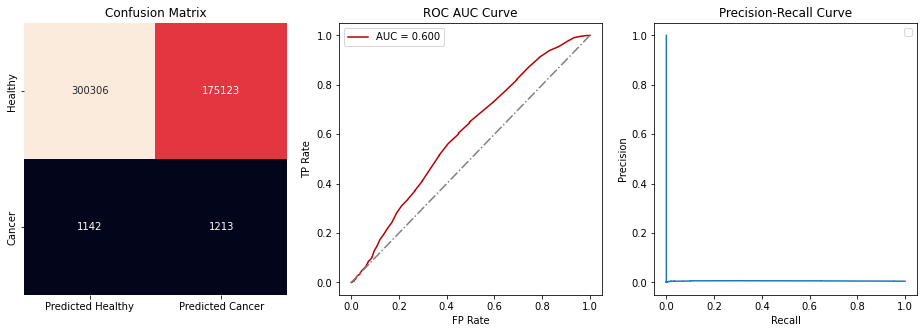

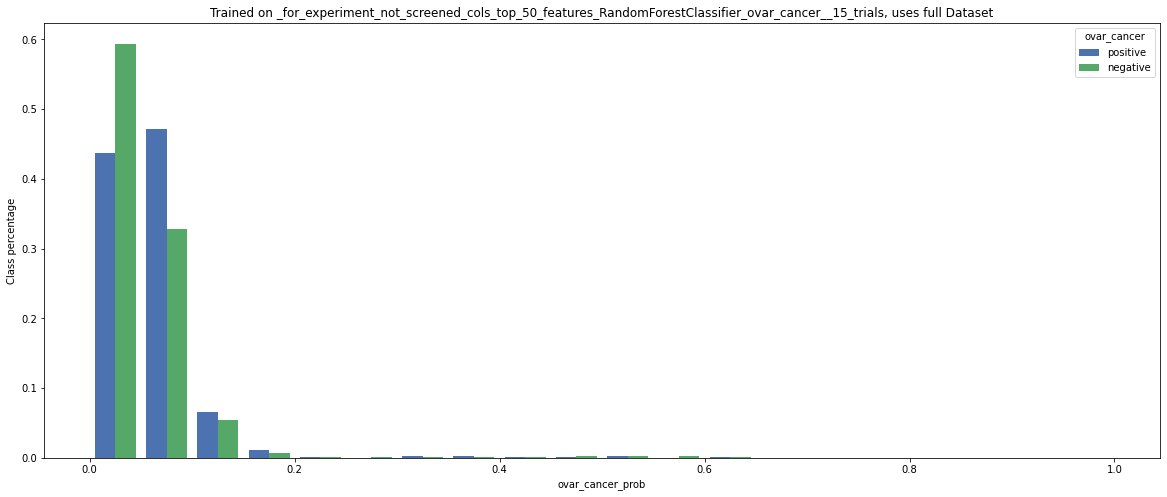

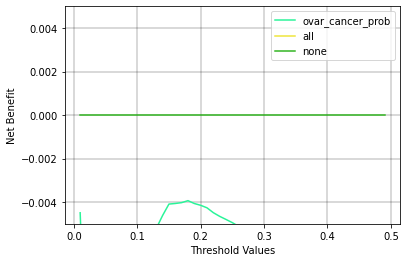

In [12]:
for filesuffix in filesuffixes:
    cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)
    print(filesuffix)
    cv_analytics_utils[filesuffix] = cv_analytics_util
    threshold = cv_analytics_util.get_optimal_operating_point()
    print(f"Threshold: {threshold}")
    cv_analytics_util.update_thresholds(threshold)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    label = cv_analytics_util.get_label()
    full_dataset = cv_analytics_util.get_dataset_with_predictions()
    plot_hist_side_by_side_for_class(full_dataset, label, f'{label}_prob', normalize = True, title=f'Trained on {filesuffix}, uses full Dataset')
    dca_obj = dca(full_dataset, outcome=label, modelnames=[f'{label}_prob'], thresholds=np.arange(0.01, 0.5, 0.01))
    plot_graphs(
        plot_df=dca_obj,
        graph_type='net_benefit',
        y_limits=[-0.005, 0.005]
    )
    dca_obj.to_csv(f"./threshold_selection/dca_curve{filesuffix}.csv")
    get_per_thereshold_metrics(full_dataset, f'{label}_prob', label).to_csv(f"./threshold_selection/threshold_metrics{filesuffix}.csv")


In [13]:
threshold

0.05

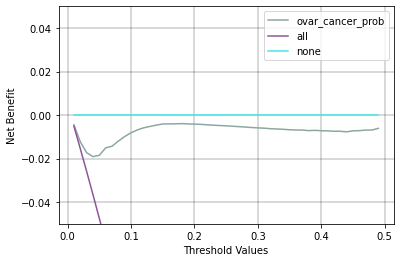

In [14]:
dca_obj = dca(full_dataset, outcome=label, modelnames=[f'{label}_prob'], thresholds=np.arange(0.01, 0.5, 0.01))
plot_graphs(
    plot_df=dca_obj,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.05]
)

In [15]:
full_dataset[full_dataset[label].isin([True])]

,ovary_trial_flag,bmi_20,pregc,miscar,fmenstr,bmi_curr,ibuppd,papsmear_history,cigpd_f,hyperten_f,...,weight50_f,study_yr,menstrs,smokea_f,age,ovar_cancer_years,cig_stop,livec,ovar_cancer_pred,ovar_cancer_prob
104,1.0,17.718750,2.0,0.0,3.0,23.906250,0.0,1.0,1.0,0.0,...,125.0,0.0,2.0,30.000000,70.0,0.0,0.000000,2.0,0.0,0.093333
253,1.0,20.375000,2.0,0.0,3.0,23.906250,2.0,2.0,1.0,0.0,...,130.0,0.0,1.0,15.000000,60.0,13.0,32.000000,2.0,0.0,0.046667
535,1.0,19.359375,3.0,0.0,3.0,21.781250,0.0,2.0,1.0,0.0,...,130.0,0.0,1.0,15.000000,60.0,8.0,0.000000,4.0,0.0,0.093333
549,1.0,24.875000,2.0,0.0,4.0,33.468750,0.0,3.0,0.0,0.0,...,155.0,-1.0,1.0,19.609375,60.0,7.0,15.281250,2.0,0.0,0.066667
563,1.0,20.593750,1.0,0.0,3.0,27.796875,0.0,2.0,2.0,0.0,...,142.0,-1.0,1.0,32.000000,65.0,11.0,15.000000,1.0,0.0,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24570,1.0,21.203125,3.0,2.0,3.0,23.406250,0.0,2.0,1.0,0.0,...,136.0,-1.0,1.0,35.000000,75.0,14.0,13.000000,1.0,0.0,0.076667
24834,1.0,21.203125,1.0,0.0,4.0,27.968750,7.0,2.0,2.0,0.0,...,180.0,-1.0,1.0,18.000000,70.0,15.0,18.000000,1.0,0.0,0.063333
25374,1.0,23.046875,0.0,0.0,3.0,20.703125,0.0,2.0,0.0,0.0,...,114.0,-1.0,1.0,19.609375,85.0,15.0,15.289062,0.0,0.0,0.043333
27002,1.0,20.250000,4.0,1.0,4.0,26.609375,4.0,0.0,0.0,0.0,...,142.0,-1.0,2.0,19.609375,75.0,15.0,15.289062,4.0,0.0,0.036667


In [16]:
print_df(dca_obj)

+-----+------------------+-------------+--------+--------------+--------+-----------------+-------------+------------+---------------+----------------------------+
|     | model            |   threshold |      n |   prevalence |   harm |   test_pos_rate |     tp_rate |    fp_rate |   net_benefit |   net_intervention_avoided |
|-----+------------------+-------------+--------+--------------+--------+-----------------+-------------+------------+---------------+----------------------------|
|   0 | ovar_cancer_prob |        0.01 | 477784 |   0.00492901 |      0 |      0.933081   | 0.00488296  | 0.928198   |   -0.00449277 |                  0.0623148 |
|   1 | ovar_cancer_prob |        0.02 | 477784 |   0.00492901 |      0 |      0.830936   | 0.00462761  | 0.826309   |   -0.0122358  |                  0.153994  |
|   2 | ovar_cancer_prob |        0.03 | 477784 |   0.00492901 |      0 |      0.693305   | 0.0040353   | 0.68927    |   -0.0172823  |                  0.276905  |
|   3 | ovar_can